# 프로젝트: Spectrogram Classification

## 0. 환경 세팅

### 소요시간 확인을 위한 autotime 라이브러리 

In [1]:
# 시간 측정 
# !pip install ipython-autotime
%load_ext autotime

time: 970 µs (started: 2021-01-28 06:48:31 +09:00)


### GPU 세팅
* 아래 두가지 모두 같은 기능을 하는 것으로 알고 있습니다! 메모리 파편화가 발생할 수 있어 유의해야합니다. 

In [2]:
import os, random
import tensorflow as tf
import numpy as np 

# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # 노드를 진행할때도 해당 코드를 한번 실행해주고 Tensorflow를 사용해보세요!

time: 1.99 s (started: 2021-01-28 06:48:32 +09:00)


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 259 ms (started: 2021-01-28 06:48:34 +09:00)


### Random seed 설정 
- 같은 결과를 유지하기 위해 설정해준다. 튜닝으로 개선할 수 도 있으나 기존 RNN을 사용한 사례에서 seed값을 일단 참고했다.

In [4]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 222
set_seeds(SEED)

time: 552 µs (started: 2021-01-28 06:48:34 +09:00)


### 설치 라이브러리 

In [5]:
# !pip install librosa
# !pip install wget

time: 182 µs (started: 2021-01-28 06:48:34 +09:00)


### 사용 라이브러리 

In [6]:
# 음성 데이터 재생
import IPython.display as ipd

# 데이터 분리
from sklearn.model_selection import train_test_split

# 모델 학습 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model #저장된 가중치 불러오기 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 빨리 끝내기, 체크포인트 모델 파일 저장

# 시각화 
import matplotlib.pyplot as plt

# FFT
import librosa
import librosa.display

time: 740 ms (started: 2021-01-28 06:48:34 +09:00)


## 1. 데이터 불러오기

### 데이터 디렉토리 만들기
디렉토리나 파일 다운로드를 이용할 때 존재 유무를 확인 후에 mkdir를 하거나, wget을 하도록 구성했습니다. 터미널하고 왔다갔다 안해도 되게끔..ㅎ

file:///home/aiffel-dj19/Downloads/def.png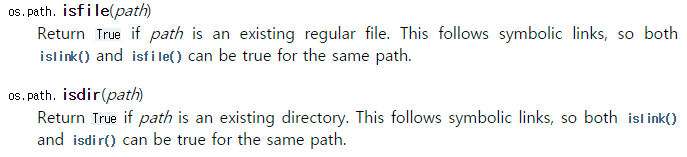

In [7]:
# import os # 위에서 이미 import 했습니다. 

project_path = os.getenv("HOME")+'/aiffel/speech_recognition'

if not os.path.isdir(project_path):
    os.mkdir(project_path)
else:
    print("project_path에 폴더가 이미 존재합니다.")

project_path에 폴더가 이미 존재합니다.
time: 1.77 ms (started: 2021-01-28 06:48:35 +09:00)


In [8]:
# 절대 경로를 줘야함. 
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data'
models_path = os.getenv("HOME")+'/aiffel/speech_recognition/models'

if not os.path.isdir(data_path):
    os.mkdir(data_path)
else:
    print("data_path에 폴더가 이미 존재합니다.")
    
if not os.path.isdir(models_path):
    os.mkdir(models_path)    
else:
    print("models_path에 폴더가 이미 존재합니다.")  

data_path에 폴더가 이미 존재합니다.
models_path에 폴더가 이미 존재합니다.
time: 2.78 ms (started: 2021-01-28 06:48:35 +09:00)


In [9]:
chkpnt_path = os.getenv("HOME")+'/aiffel/speech_recognition/models/spec'
chkpnt_skip_path = os.getenv("HOME")+'/aiffel/speech_recognition/models/spec_skip'

if not os.path.isdir(chkpnt_path):
    os.mkdir(chkpnt_path)    
else:
    print("chkpnt_path에 폴더가 이미 존재합니다.")  
    
if not os.path.isdir(chkpnt_skip_path):
    os.mkdir(chkpnt_skip_path)    
else:
    print("chkpnt_skip_path에 폴더가 이미 존재합니다.")  

chkpnt_path에 폴더가 이미 존재합니다.
chkpnt_skip_path에 폴더가 이미 존재합니다.
time: 4.4 ms (started: 2021-01-28 06:48:36 +09:00)


In [10]:
# !pip install wget

time: 629 µs (started: 2021-01-28 06:48:36 +09:00)


In [11]:
import wget

url = 'https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz'
npz_path = data_path + '/speech_wav_8000.npz'

if not os.path.isfile(npz_path):
    wget.download(url, out = npz_path)

else:
    print("speech_wav_8000.npz가 이미 존재합니다.")

speech_wav_8000.npz가 이미 존재합니다.
time: 2.42 ms (started: 2021-01-28 06:48:36 +09:00)


## 2. 데이터 열어보기

In [12]:
speech_data = np.load(npz_path)

time: 3.47 ms (started: 2021-01-28 06:48:37 +09:00)


In [13]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
time: 2.1 s (started: 2021-01-28 06:48:37 +09:00)


In [14]:
# import random # 앞에서 한번 import해준 패키지 

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  7071
Wave data shape :  (8000,)
label :  ['no']


time: 3.22 s (started: 2021-01-28 06:48:39 +09:00)


## 3. Train/Test dataset 구성하기 

### Label data 처리
전체 데이터셋인 Speech data에서 라벨들의 유일한 값을 확인함으로써 target list를 찾았습니다. 

In [15]:
target_list = np.unique(speech_data["label_vals"]).tolist()
print("{}개의 label: {}".format(len(target_list), target_list))

12개의 label: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
time: 6.37 ms (started: 2021-01-28 06:48:43 +09:00)


In [16]:
label_value = target_list
# label_value.append('unknown')
# label_value.append('silence') # 예제에서 추가해주다보니 append함 비효율적..?

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
Indexed LABEL :  {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 8, 'unknown': 9, 'up': 10, 'yes': 11}
time: 653 µs (started: 2021-01-28 06:48:43 +09:00)


In [17]:
temp = []

for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([0, 0, 0, ..., 7, 7, 7])

time: 31.6 ms (started: 2021-01-28 06:48:43 +09:00)


### 학습을 위한 데이터 분리

In [18]:
# sr = 8000
# test size = 0.1 -> 0.2 실험적으로 변경할 것.
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
# print(train_wav)

# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])

time: 1.88 s (started: 2021-01-28 06:48:43 +09:00)


In [19]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (40496, 8000)
train labels :  (40496,)
test data :  (10124, 8000)
test labels :  (10124,)
time: 558 µs (started: 2021-01-28 06:48:44 +09:00)


In [20]:
train_wav[:3]

array([[-7.4485224e-04, -1.7483678e-03, -2.1770848e-03, ...,
         9.8829111e-04,  1.5912023e-03,  1.6358850e-03],
       [ 7.5144297e-04, -1.7734687e-03, -5.9522833e-03, ...,
        -1.0825286e-03,  2.1712843e-03, -4.4155167e-03],
       [ 3.2938202e-03,  4.7343327e-03,  8.2739476e-05, ...,
         2.4794049e-03,  2.1441355e-03, -1.8533438e-03]], dtype=float32)

time: 1.61 ms (started: 2021-01-28 06:48:44 +09:00)


#### Kernel dead 현상 방지를 위해 dataset 줄이기
셔플 완료 후에 Crop해줘야 데이터가 편중되어 잘리는 것을 방지할 수 있어서 스플릿(shuffle = True)을 한번 해준 후에 진행합니다. 

In [21]:
train_crop = 35000
test_crop = 7000

train_wav = np.delete(train_wav, list(range(train_crop,len(train_wav))), axis = 0)
test_wav = np.delete(test_wav, list(range(test_crop,len(test_wav))), axis = 0)
train_label = np.delete(train_label, list(range(train_crop,len(train_label))), axis = 0)
test_label = np.delete(test_label, list(range(test_crop,len(test_label))), axis = 0)
# train_wav[:3]

time: 238 ms (started: 2021-01-28 06:48:44 +09:00)


In [22]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (35000, 8000)
train labels :  (35000,)
test data :  (7000, 8000)
test labels :  (7000,)
time: 726 µs (started: 2021-01-28 06:48:45 +09:00)


### Data setting
* tf.data.Dataset을 이용
* from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
* map과 batch를 이용한 데이터 전처리
* 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
* tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

#### Spectrogram
wav는 소리 파동의 높이 값(float형)을 일정한 **시간** 간격(sampling rate, sr)마다 기록한 실수의 배열입니다.    
Spectrogram은 **Frequency** spectrum입니다. 두 변수는 도메인이 시간 도메인이냐, 주파수 도메인이냐로 나눠집니다.    
그래서 wav2spec을 통해 fft를 거쳐 시간과 소리 파동의 높이(amplitude)가 주파수, magnitude로 바뀌어 표현됩니다. 
* https://newsight.tistory.com/294

In [23]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

time: 427 µs (started: 2021-01-28 06:48:45 +09:00)


In [24]:
# wav2spec for Train wav dataset - 33s 소요 
train_spec = []

for wav in train_wav:
    train_spec.append(wav2spec(wav))

# list to array 
train_spec = np.array(train_spec)

print("Train Waveform shape : ",train_wav.shape)
print("Train Spectrogram shape : ",train_spec.shape)

Train Waveform shape :  (35000, 8000)
Train Spectrogram shape :  (35000, 130, 126)
time: 26.2 s (started: 2021-01-28 06:48:45 +09:00)


In [25]:
# wav2spec for Test wav dataset - 3s 소요
test_spec = []

for wav in test_wav:
    test_spec.append(wav2spec(wav))

# list to array
test_spec = np.array(test_spec)

print("Test Waveform shape : ",test_wav.shape)
print("Test Spectrogram shape : ",test_spec.shape)

Test Waveform shape :  (7000, 8000)
Test Spectrogram shape :  (7000, 130, 126)
time: 5.06 s (started: 2021-01-28 06:49:11 +09:00)


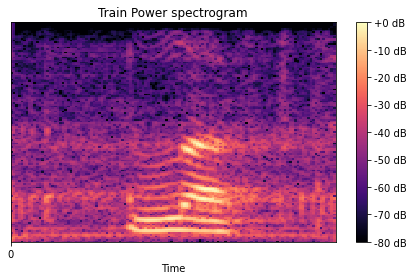

time: 189 ms (started: 2021-01-28 06:49:16 +09:00)


In [26]:
librosa.display.specshow(librosa.amplitude_to_db(train_spec[0], ref=np.max), x_axis='time')
plt.title('Train Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

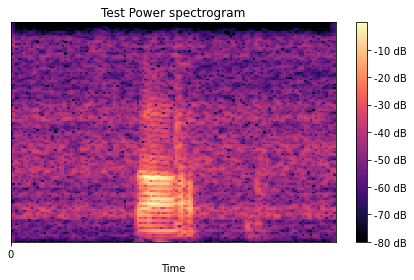

time: 123 ms (started: 2021-01-28 06:49:16 +09:00)


In [27]:
librosa.display.specshow(librosa.amplitude_to_db(test_spec[0], ref=np.max), x_axis='time')
plt.title('Test Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### Tensor로 mapping & Label encoding

#### Add channel for CNN Input shape

In [28]:
sr = train_spec.shape[1]
sc = train_spec.shape[2]

train_addchannel = [-1,sr, sc, 1]
test_addchannel = [-1,sr, sc, 1]
train_spec = train_spec.reshape(train_addchannel) # add channel for CNN
test_spec = test_spec.reshape(test_addchannel)

print(train_spec.shape)
print(test_spec.shape)

(35000, 130, 126, 1)
(7000, 130, 126, 1)
time: 632 µs (started: 2021-01-28 06:49:16 +09:00)


#### Hyper-parameters setting

In [29]:
batch_size = 16 # 32 -> 16 메모리 부족 방지 
max_epochs = 10
learning_rate = 1e-4

time: 456 µs (started: 2021-01-28 06:49:16 +09:00)


#### One-hot encoding

In [30]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

time: 455 µs (started: 2021-01-28 06:49:16 +09:00)


In [31]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
time: 897 ms (started: 2021-01-28 06:50:36 +09:00)


#### 메모리 버퍼 비우기

In [32]:
del speech_data

time: 359 µs (started: 2021-01-28 06:50:36 +09:00)


## 4. Wave classification 모델 구현 
2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능, Conv1D와 Conv2D의 차이는 출력값의 차원이 다르다는 점이다. 합성곱되는 방식에도 약간의 차이가 있다. 합성곱의 방향이 한 방향이면 1D, 두 방향(x, y)면 2D와 같은 차이 입니다. 
* 참고 사이트: https://wiserloner.tistory.com/906
* 공식 문서: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

### Conv2D 활용한 모델 구성

In [33]:
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x) # 256 -> 128
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### Loss Optimizer

In [34]:
optimizer=tf.keras.optimizers.Adam(learning_rate)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

time: 8.82 ms (started: 2021-01-28 06:50:41 +09:00)


### Training

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

time: 1.13 ms (started: 2021-01-28 06:50:42 +09:00)


In [36]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(chkpnt_path + '/spec',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

time: 442 µs (started: 2021-01-28 06:50:42 +09:00)


In [37]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, cp_callback]
                    )

Epoch 1/10
2187/2187 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7739
Epoch 00001: val_loss improved from inf to 0.34387, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec/spec
2187/2187 [==============================] - 164s 75ms/step - loss: 0.7197 - accuracy: 0.7739 - val_loss: 0.3439 - val_accuracy: 0.8987
Epoch 2/10
2187/2187 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9229
Epoch 00002: val_loss improved from 0.34387 to 0.21827, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec/spec
2187/2187 [==============================] - 160s 73ms/step - loss: 0.2569 - accuracy: 0.9229 - val_loss: 0.2183 - val_accuracy: 0.9305
Epoch 3/10
2187/2187 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9502
Epoch 00003: val_loss improved from 0.21827 to 0.16213, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec/spec
2187/2187 [============================

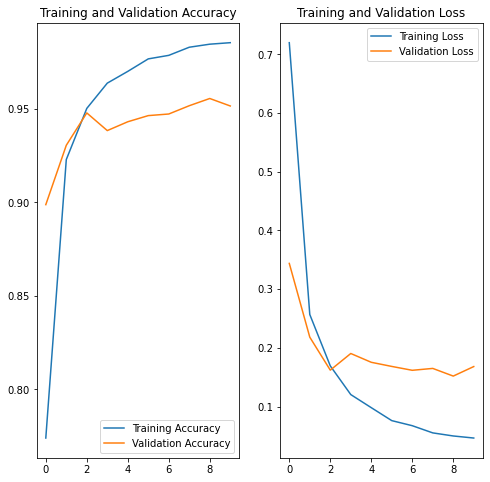

time: 224 ms (started: 2021-01-28 07:18:10 +09:00)


In [38]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation

In [40]:
model_spec.load_weights(chkpnt_path + '/spec')

time: 117 ms (started: 2021-01-28 07:19:42 +09:00)


In [41]:
results = model_spec.evaluate(test_dataset)

438/438 [==============================] - 17s 39ms/step - loss: 0.1521 - accuracy: 0.9554
time: 17.6 s (started: 2021-01-28 07:19:43 +09:00)


In [42]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.152
accuracy value: 95.5429%
time: 542 µs (started: 2021-01-28 07:20:01 +09:00)


### Model Test 
y_pred를 확인하는 방법은 model.fit을 Training = False하거나, predict로 확인할 수 있다.  predict가 큰 데이터셋에서 빠르게 동작한다고해서 predict를 사용합니다. 
> For small amount of inputs that fit in one batch, directly using __call__ is recommended for faster execution, e.g., model(x), or model(x, training=False) if you have layers such as tf.keras.layers.BatchNormalization that behaves differently during inference. Also, note the fact that test loss is not affected by regularization layers like noise and dropout.
* 참고: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
    
target list가 딕셔너리 형태로 저장되어 있는 label value는 키값과 value 값이 {'down':0}과 같은 형태로 되어있습니다. 키를 통해 라벨의 'down'과 같은 문자열을 보여주기 위해 for문으로 value와 키값을 바꿔줍니다.

In [58]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]

y_pred_ = model_spec.predict(batch_xs)

print("label : ", str(inv_label_value[batch_ys[0]]))

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
    
# # spectrogram to wav 
# batch_xs = batch_xs.reshape(sc, sr)
# batch_xs = librosa.feature.inverse.mel_to_audio(batch_xs)

# ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  stop
y_pred: stop(Correct!)
time: 55.7 ms (started: 2021-01-28 07:41:55 +09:00)


#### 메모리 버퍼 비우기
하이퍼 파라미터를 조절해서 버퍼 비우기를 해주지 않아도 커널 데드 현상이 나타나지 않았습니다. 

In [70]:
# del history_spec
# del model_spec

time: 455 µs (started: 2021-01-28 08:17:35 +09:00)


## 5. Skip-connection model 추가 

### 모델 수정 

In [59]:
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

# x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = tf.concat([x, skip_3], -1)
# x = layers.MaxPool2D()(x)
# x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x) # 256 -> 128
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

# model_spec_skip.summary()

time: 121 ms (started: 2021-01-28 07:42:20 +09:00)


### Loss & Optimizer 

In [60]:
optimizer=tf.keras.optimizers.Adam(learning_rate)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

time: 7.61 ms (started: 2021-01-28 07:42:21 +09:00)


### Model 학습 

In [61]:
# the save point
chkpnt_skip_path = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

cp_callback = tf.keras.callbacks.ModelCheckpoint(chkpnt_skip_path + '/spec_skip',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

time: 641 µs (started: 2021-01-28 07:42:22 +09:00)


In [62]:
#30분 내외 소요
# with tf.device('/gpu:0'): 
    
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, cp_callback]
                    )

Epoch 1/10
2187/2187 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7944
Epoch 00001: val_loss improved from inf to 0.30070, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec_skip/spec_skip
2187/2187 [==============================] - 183s 83ms/step - loss: 0.6556 - accuracy: 0.7944 - val_loss: 0.3007 - val_accuracy: 0.9046
Epoch 2/10
2187/2187 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9378
Epoch 00002: val_loss improved from 0.30070 to 0.22841, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec_skip/spec_skip
2187/2187 [==============================] - 178s 81ms/step - loss: 0.2124 - accuracy: 0.9378 - val_loss: 0.2284 - val_accuracy: 0.9262
Epoch 3/10
2187/2187 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9644
Epoch 00003: val_loss improved from 0.22841 to 0.17594, saving model to /home/aiffel-dj19/aiffel/speech_recognition/models/spec_skip/spec_skip
2187/2187

### Model 시각화 

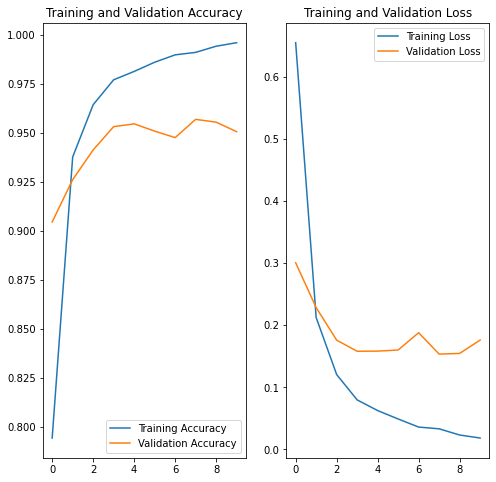

time: 249 ms (started: 2021-01-28 08:12:42 +09:00)


In [63]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation 

In [68]:
# Evaluation 
model_spec_skip.load_weights(chkpnt_skip_path + '/spec_skip')
results = model_spec_skip.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

438/438 [==============================] - 10s 22ms/step - loss: 0.1538 - accuracy: 0.9569
loss value: 0.154
accuracy value: 95.6857%
time: 10.3 s (started: 2021-01-28 08:15:11 +09:00)


### Test 

In [69]:
y_pred_ = model_spec_skip.predict(batch_xs)

print("label : ", str(inv_label_value[batch_ys[0]]))

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  stop
y_pred: stop(Correct!)
time: 1.84 s (started: 2021-01-28 08:15:22 +09:00)


## 5. 목표(루브릭)
* 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
    - 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
        - train data :  (35000, 8000)
        - train labels :  (35000,)
        - test data :  (7000, 8000)
        - test labels :  (7000,)
* 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
    - 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
        - Spectrogram을 다시 Audio로 출력하기 위해서는 librosa 패키지의 librosa.feature.inverse.mel_to_audio를 사용한다.
        - 참고: https://librosa.org/doc/main/generated/librosa.feature.inverse.mel_to_audio.html
* 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
    - evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
        - skip connection 없을 때 evaluation 결과: loss value: 0.152, accuracy value: 95.5429%
        - skip connection 있을 때 evaluation 결과: loss value: 0.154, accuracy value: 95.6857%

## 6. 정리
* Conv1D, Con2D 차이점 - 4번
* skip connection(=identity mapping = shortcut connections)을 사용한 경우가 정확도가 더 높은 이유?
예제보다는 Skip connection을 적용했을 때 정확도가 큰 변화를 보이진 않았다. Skip connection은 그럼 왜 좋다는 것일까? 이번 모델에서는 Layer가 여러 층을 쌓아간다. 여러층을 쌓다보면 소실되는 gradient(<=> 가중치 정보)가 발생하게 된다. 이를 방지하기 위해서 skip connection을 사용한다.    
skip connection은 지름길을 의미한다. 이전 gradient가 다음 단에 더 잘 흐르게 하기 위해 지름길을 놔주는 것이다. 따라서 identity mapping은 이전보다 나은 상황을 만들어낸다. 하지만, 이전 케이스를 참고하는 것이 반복적으로 이뤄진다는 점 때문에 항상 좋은 것만은 아니다? 안 좋은 경우는 아래 블로그를 읽으면서 참고했는데 명확히 이해가 되진 않았다. 
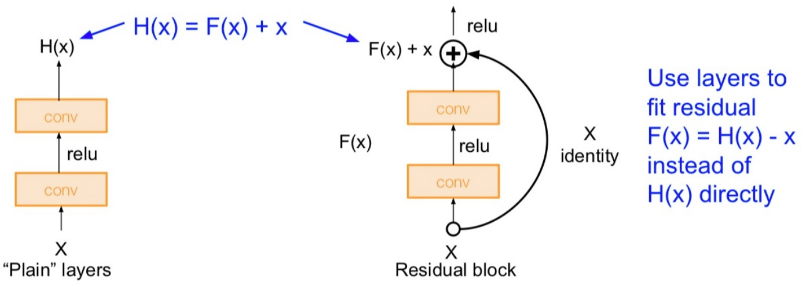
참고: https://sensibilityit.tistory.com/517

## 7. 회고
* 디버깅
    - Out of Memory Error 
        * dataset 줄이기: 50600개 -> 42000개
        * batch size 줄이기: 32 -> 16
        * filter 개수: x
        * Layer: 256 3층 빼기
    
    - Input shape Error
        * (wav)8000 -> (spectrogram)130*126 
    
* 헷갈렸던 부분 
    - spectrogram 재생을 위해, 다시 spec2wav 하는 과정: 방법만 찾아보고 x
        
* 추가로 공부해야할 부분 
    - validation set과 test set의 구분
    - wav를 분석하는 다른 방법 